# Markov Model and Markov Chains - T-Pot - Cowrie Honeypot
author: Austin Hogan
contact: a1hogan@ryerson.ca

Hidden Markov models (HMM)

In [19]:
import numpy
numpy.random.seed(42)
print(numpy.__path__)

%matplotlib inline
import pandas as pd
import random
import numpy
import matplotlib.pyplot as plt
import pomegranate
import seaborn; seaborn.set_style('whitegrid')
import traceback

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from hmmviz import TransGraph
from hmmlearn import hmm
from pprint import pprint

random.seed(0)
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate,pandas,hmmlearn

['c:\\Users\\Austin Hogan\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\numpy']
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.23.1
scipy      : 1.8.1
pomegranate: 0.14.8
pandas     : 1.4.3
hmmlearn   : 0.2.7

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 8 Stepping 2, AuthenticAMD
CPU cores   : 32
Architecture: 64bit



In [20]:
# Hive Information Class
class HiveInfo:
    def __init__(self) -> None:
        self.city = None,
        self.country = None
        self.code_name = None
        self.ip = None

In [21]:
# populate hive information
hive_base = HiveInfo()
hive_sensors = [HiveInfo(), HiveInfo(), HiveInfo(), HiveInfo(), HiveInfo(), HiveInfo()]
# sink
hive_base.city = "Toronto"
hive_base.country = "Canada"
hive_base.code_name = "realtatami"
hive_base.ip = "99.251.10.123"
# src 0
hive_sensors[0].city = "Toronto"
hive_sensors[0].country = "Canada"
hive_sensors[0].code_name = "rulingcommittee"
hive_sensors[0].ip = "216.238.83.8"
# src 1
hive_sensors[1].city = "Seoul"
hive_sensors[1].country = "Korea"
hive_sensors[1].code_name = "attractivescow"
hive_sensors[1].ip = "158.247.238.143"
# src 2
hive_sensors[2].city = "Melbourne"
hive_sensors[2].country = "Austrailia"
hive_sensors[2].code_name = "deadinlay"
hive_sensors[2].ip = "67.219.98.203"
# src 3
hive_sensors[3].city = "Stockholm"
hive_sensors[3].country = "Sweden"
hive_sensors[3].code_name = "longtermresult"
hive_sensors[3].ip = "65.20.115.181"
# src 4
hive_sensors[4].city = "Mumbai"
hive_sensors[4].country = "India"
hive_sensors[4].code_name = "sadproduce"
hive_sensors[4].ip = "65.20.68.106"
# src 5
hive_sensors[5].city = "Los Angeles"
hive_sensors[5].country = "United States"
hive_sensors[5].code_name = "resonantnorse"
hive_sensors[5].ip = "149.248.9.4"

In [22]:
def query_es_return_dataframe(index, query): # query es instance and return dataframe
    search_context = Search(using=es, index=index)
    s = search_context.query("query_string", query=query)
    response = s.execute()
    if response.success():
        df = pd.DataFrame((d.to_dict() for d in s.scan()))
    return df

In [23]:
# connect with local T-Pot instance, contains backup from honeypot cluster
es = Elasticsearch("http://localhost:9200")
indice_search_tag = "logstash-20*"

In [24]:
dfs = []
for hive_sensor in hive_sensors:
    print(pprint(vars(hive_sensor)))
    df = query_es_return_dataframe(indice_search_tag, f"type.keyword: \"Cowrie\" AND t-pot_hostname.keyword: \"{hive_sensor.code_name}\"")
    # show  dataframe
    df.info()
    # collect data frame
    dfs.append(df)
# merge all useful dataframes
super_df = pd.concat(dfs)

{'city': 'Toronto',
 'code_name': 'rulingcommittee',
 'country': 'Canada',
 'ip': '216.238.83.8'}
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41679 entries, 0 to 41678
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geoip_ext        41679 non-null  object 
 1   message          41661 non-null  object 
 2   tags             41679 non-null  object 
 3   @version         41679 non-null  object 
 4   geoip            41679 non-null  object 
 5   session          41679 non-null  object 
 6   @timestamp       41679 non-null  object 
 7   src_ip           41679 non-null  object 
 8   host             41679 non-null  object 
 9   sensor           41679 non-null  object 
 10  path             41679 non-null  object 
 11  type             41679 non-null  object 
 12  password         7327 non-null   object 
 13  t-pot_ip_int     41679 non-null  object 
 14  eventid          41679 non-null  object 
 15  t

In [25]:
def process_dataframe(idx, df):
    # sort unique event ids and drop unused values
    event_ids = df['eventid'].unique()
    unique_event_ids = []
    for ei in event_ids:
        if isinstance(ei, str):
            unique_event_ids.append(ei)
    unique_event_ids.sort()
    print(f"Number of unique event ids {len(unique_event_ids)}")
    # pretty print unique event ids
    event_id_from_int = {}
    int_from_event_id = {}
    for i, unique_event_id in enumerate(unique_event_ids):
        print("{:02d} {}".format(i, unique_event_id))
        event_id_from_int[i] = unique_event_id
        int_from_event_id[unique_event_id] = i
    # resolve timestamp to real date
    df['@timestamp'] = pd.to_datetime(df['@timestamp'])
    # sort by date
    df = df.sort_values(['@timestamp'])
    # verify dates are sorted
    df['@timestamp']
    # group dataframe by session and aggregate eventids
    df_grouped = df.groupby("session")['eventid'].agg(list)
    # checking one example to verify sort and command order makes sense
    df_grouped[1]
    # calculate and show number of interactions per session
    number_of_interactions_per_session = len(df) / len(df_grouped)
    print("Average Number of Interactions per session {}".format(number_of_interactions_per_session))
    # calculate markov probabalities
    # note total transitions
    total_transitions = 0
    # transition dictionary collection
    transition_dict = {}
    # transition matrix (N X N) where N is the number of states
    for event_id in unique_event_ids:
        transition_dict[event_id] = [0] * len(unique_event_ids)
    # prepate data for fit
    np_fit_data = []
    np_fit_data_hmm = []
    np_fit_data_lengths = []
    # iterate over grouped session and state
    # populate transition dictionary
    for session, states in df_grouped.items():
        for i in range(len(states) - 1):
            transition_dict[states[i]][int_from_event_id[states[i+1]]] += 1
        # prepare data for fit
        states_as_ints = []
        states_as_ints_hmm = []
        for state in states:
            states_as_ints.append(int_from_event_id[state])
            states_as_ints_hmm.append([int_from_event_id[state]])
        np_fit_data.append(states_as_ints)
        np_fit_data_hmm += states_as_ints_hmm
    np_fit_data_lengths = list(map(len, np_fit_data))

    # put transition data into dataframe for makov visualization
    transition_df = pd.DataFrame(columns=unique_event_ids, index=unique_event_ids)
    for row_event_id, col_event_int in transition_dict.items():
        total = sum(col_event_int)
        transition_df.loc[row_event_id] = [(v / total if total > 0 else 0) for v in col_event_int]
        # create graph of system
    print(transition_df)
    graph = TransGraph(transition_df)

    fig = plt.figure(1*idx, figsize=(75, 75))

    graph.draw(
        nodefontsize=25,
    )
    # graphical representation of markov chains and their strength
    plt.show()
    # print(np_fit_data)
    print(f"Number of sequences: {len(np_fit_data)}")
    # pomegranate models
    model_pom = None
    # model_pom = pomegranate.HiddenMarkovModel.from_samples(pomegranate.DiscreteDistribution, n_components=len(unique_event_ids), X=np_fit_data)
    # model_pom.bake(verbose=True)
    # plt.figure(2*idx , figsize=(100, 100))
    # # a plot of the state machine and the probabilities
    # model_pom.plot()
    # hmm learn models
    model_hmm = hmm.MultinomialHMM(n_components=len(unique_event_ids), verbose=True, n_iter=20).fit(np_fit_data_hmm, np_fit_data_lengths)
    fig, ax = plt.subplots()
    ax.imshow(model_hmm.transmat_, aspect='auto', cmap='spring')
    ax.set_title('Transition Matrix')
    ax.set_xlabel('State To')
    ax.set_ylabel('State From')
    return (model_pom, model_hmm, np_fit_data_hmm, np_fit_data_lengths)

{'city': 'Toronto',
 'code_name': 'rulingcommittee',
 'country': 'Canada',
 'ip': '216.238.83.8'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41679 entries, 0 to 41678
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geoip_ext        41679 non-null  object 
 1   message          41661 non-null  object 
 2   tags             41679 non-null  object 
 3   @version         41679 non-null  object 
 4   geoip            41679 non-null  object 
 5   session          41679 non-null  object 
 6   @timestamp       41679 non-null  object 
 7   src_ip           41679 non-null  object 
 8   host             41679 non-null  object 
 9   sensor           41679 non-null  object 
 10  path             41679 non-null  object 
 11  type             41679 non-null  object 
 12  password         7327 non-null   object 
 13  t-pot_ip_int     41679 non-null  object 
 14  eventid          41679 non-null  object 
 15  t-pot_

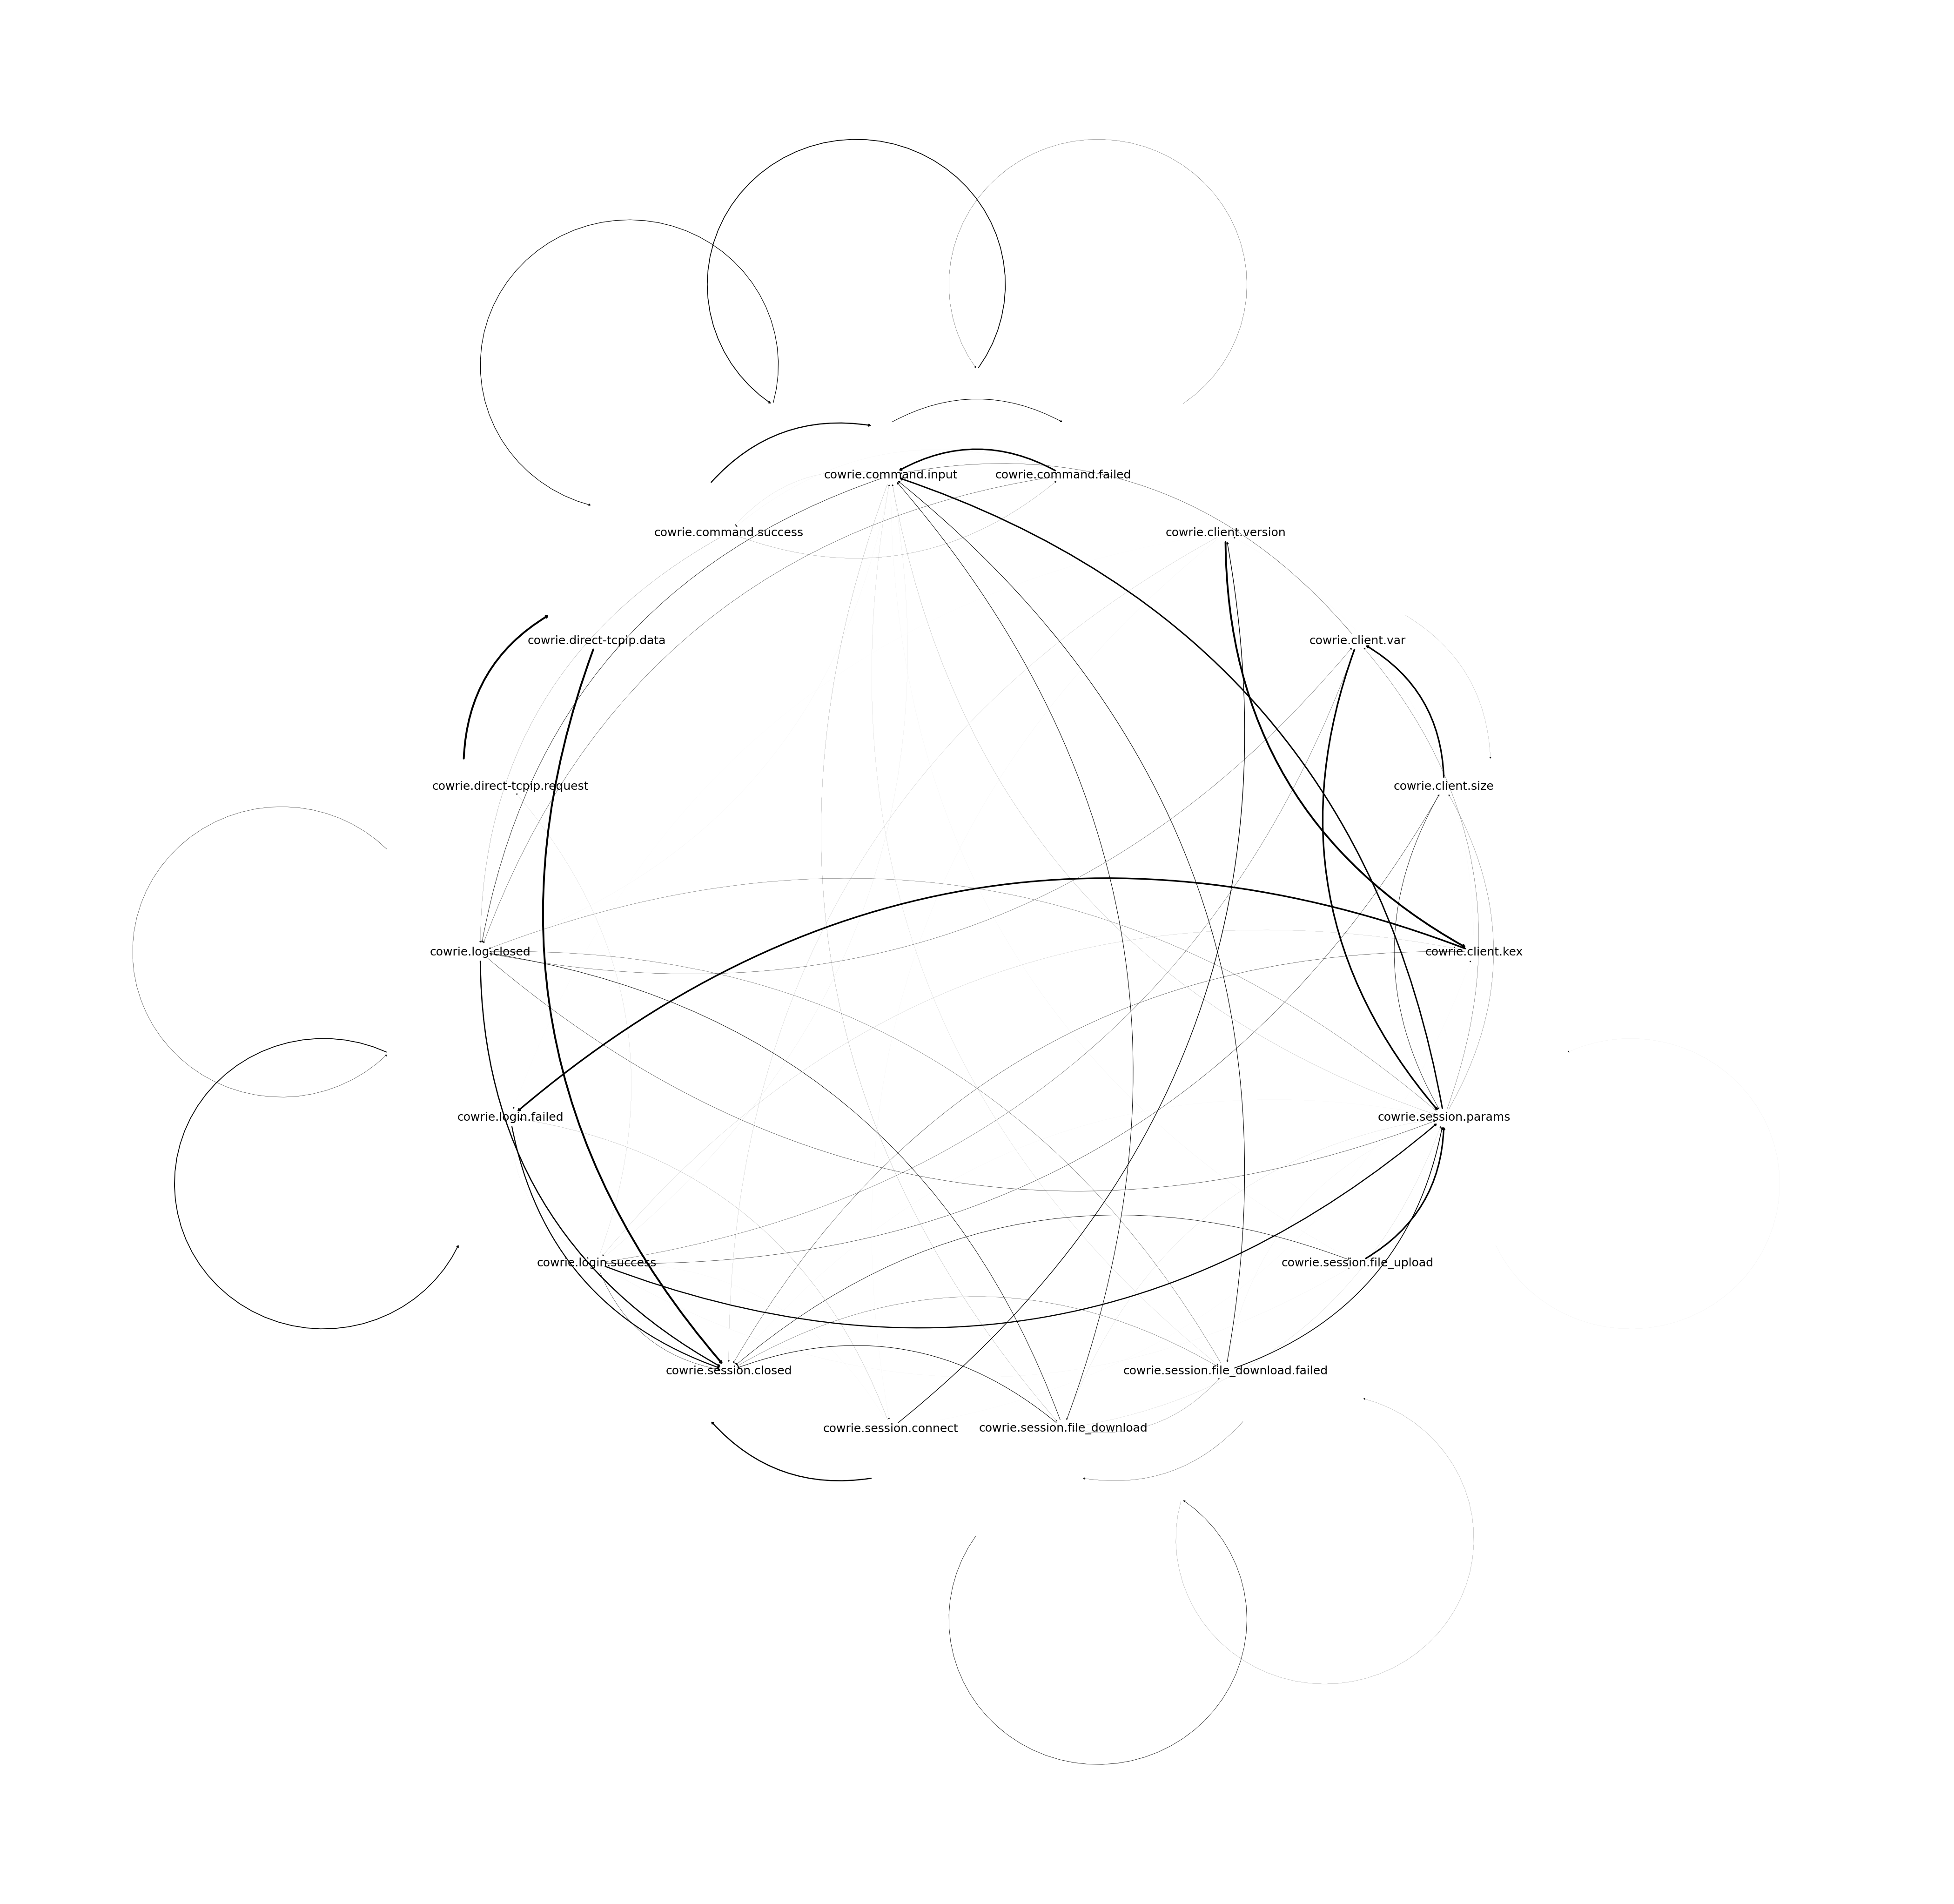

Number of sequences: 12131


         1     -116293.2779             +nan
         2      -67822.1584      +48471.1194
         3      -62194.6898       +5627.4687
         4      -53015.5473       +9179.1425
         5      -42006.3979      +11009.1494
         6      -32676.6818       +9329.7161
         7      -28519.9372       +4156.7446
         8      -25980.5910       +2539.3463
         9      -23492.1661       +2488.4248
        10      -22706.2945        +785.8716
        11      -22354.0637        +352.2308
        12      -22117.4216        +236.6421
        13      -21968.0997        +149.3220
        14      -21867.7565        +100.3432
        15      -21784.7249         +83.0315
        16      -21713.5292         +71.1958
        17      -21653.1328         +60.3964
        18      -21604.9532         +48.1795
        19      -21568.1918         +36.7614
        20      -21539.0164         +29.1754


{'city': 'Seoul',
 'code_name': 'attractivescow',
 'country': 'Korea',
 'ip': '158.247.238.143'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11849 entries, 0 to 11848
Data columns (total 51 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   message          11839 non-null  object 
 1   @timestamp       11849 non-null  object 
 2   type             11849 non-null  object 
 3   dest_port        3988 non-null   float64
 4   dest_ip          3988 non-null   object 
 5   host             11849 non-null  object 
 6   src_port         3980 non-null   float64
 7   session          11849 non-null  object 
 8   tags             11849 non-null  object 
 9   timestamp        11849 non-null  object 
 10  @version         11849 non-null  object 
 11  geoip_ext        11849 non-null  object 
 12  src_ip           11849 non-null  object 
 13  t-pot_ip_int     11849 non-null  object 
 14  event            6098 non-null   object 
 15  eventid

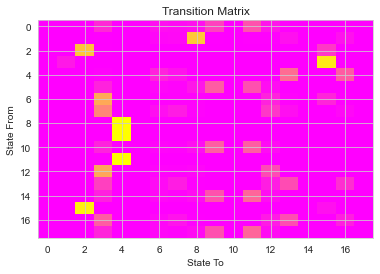

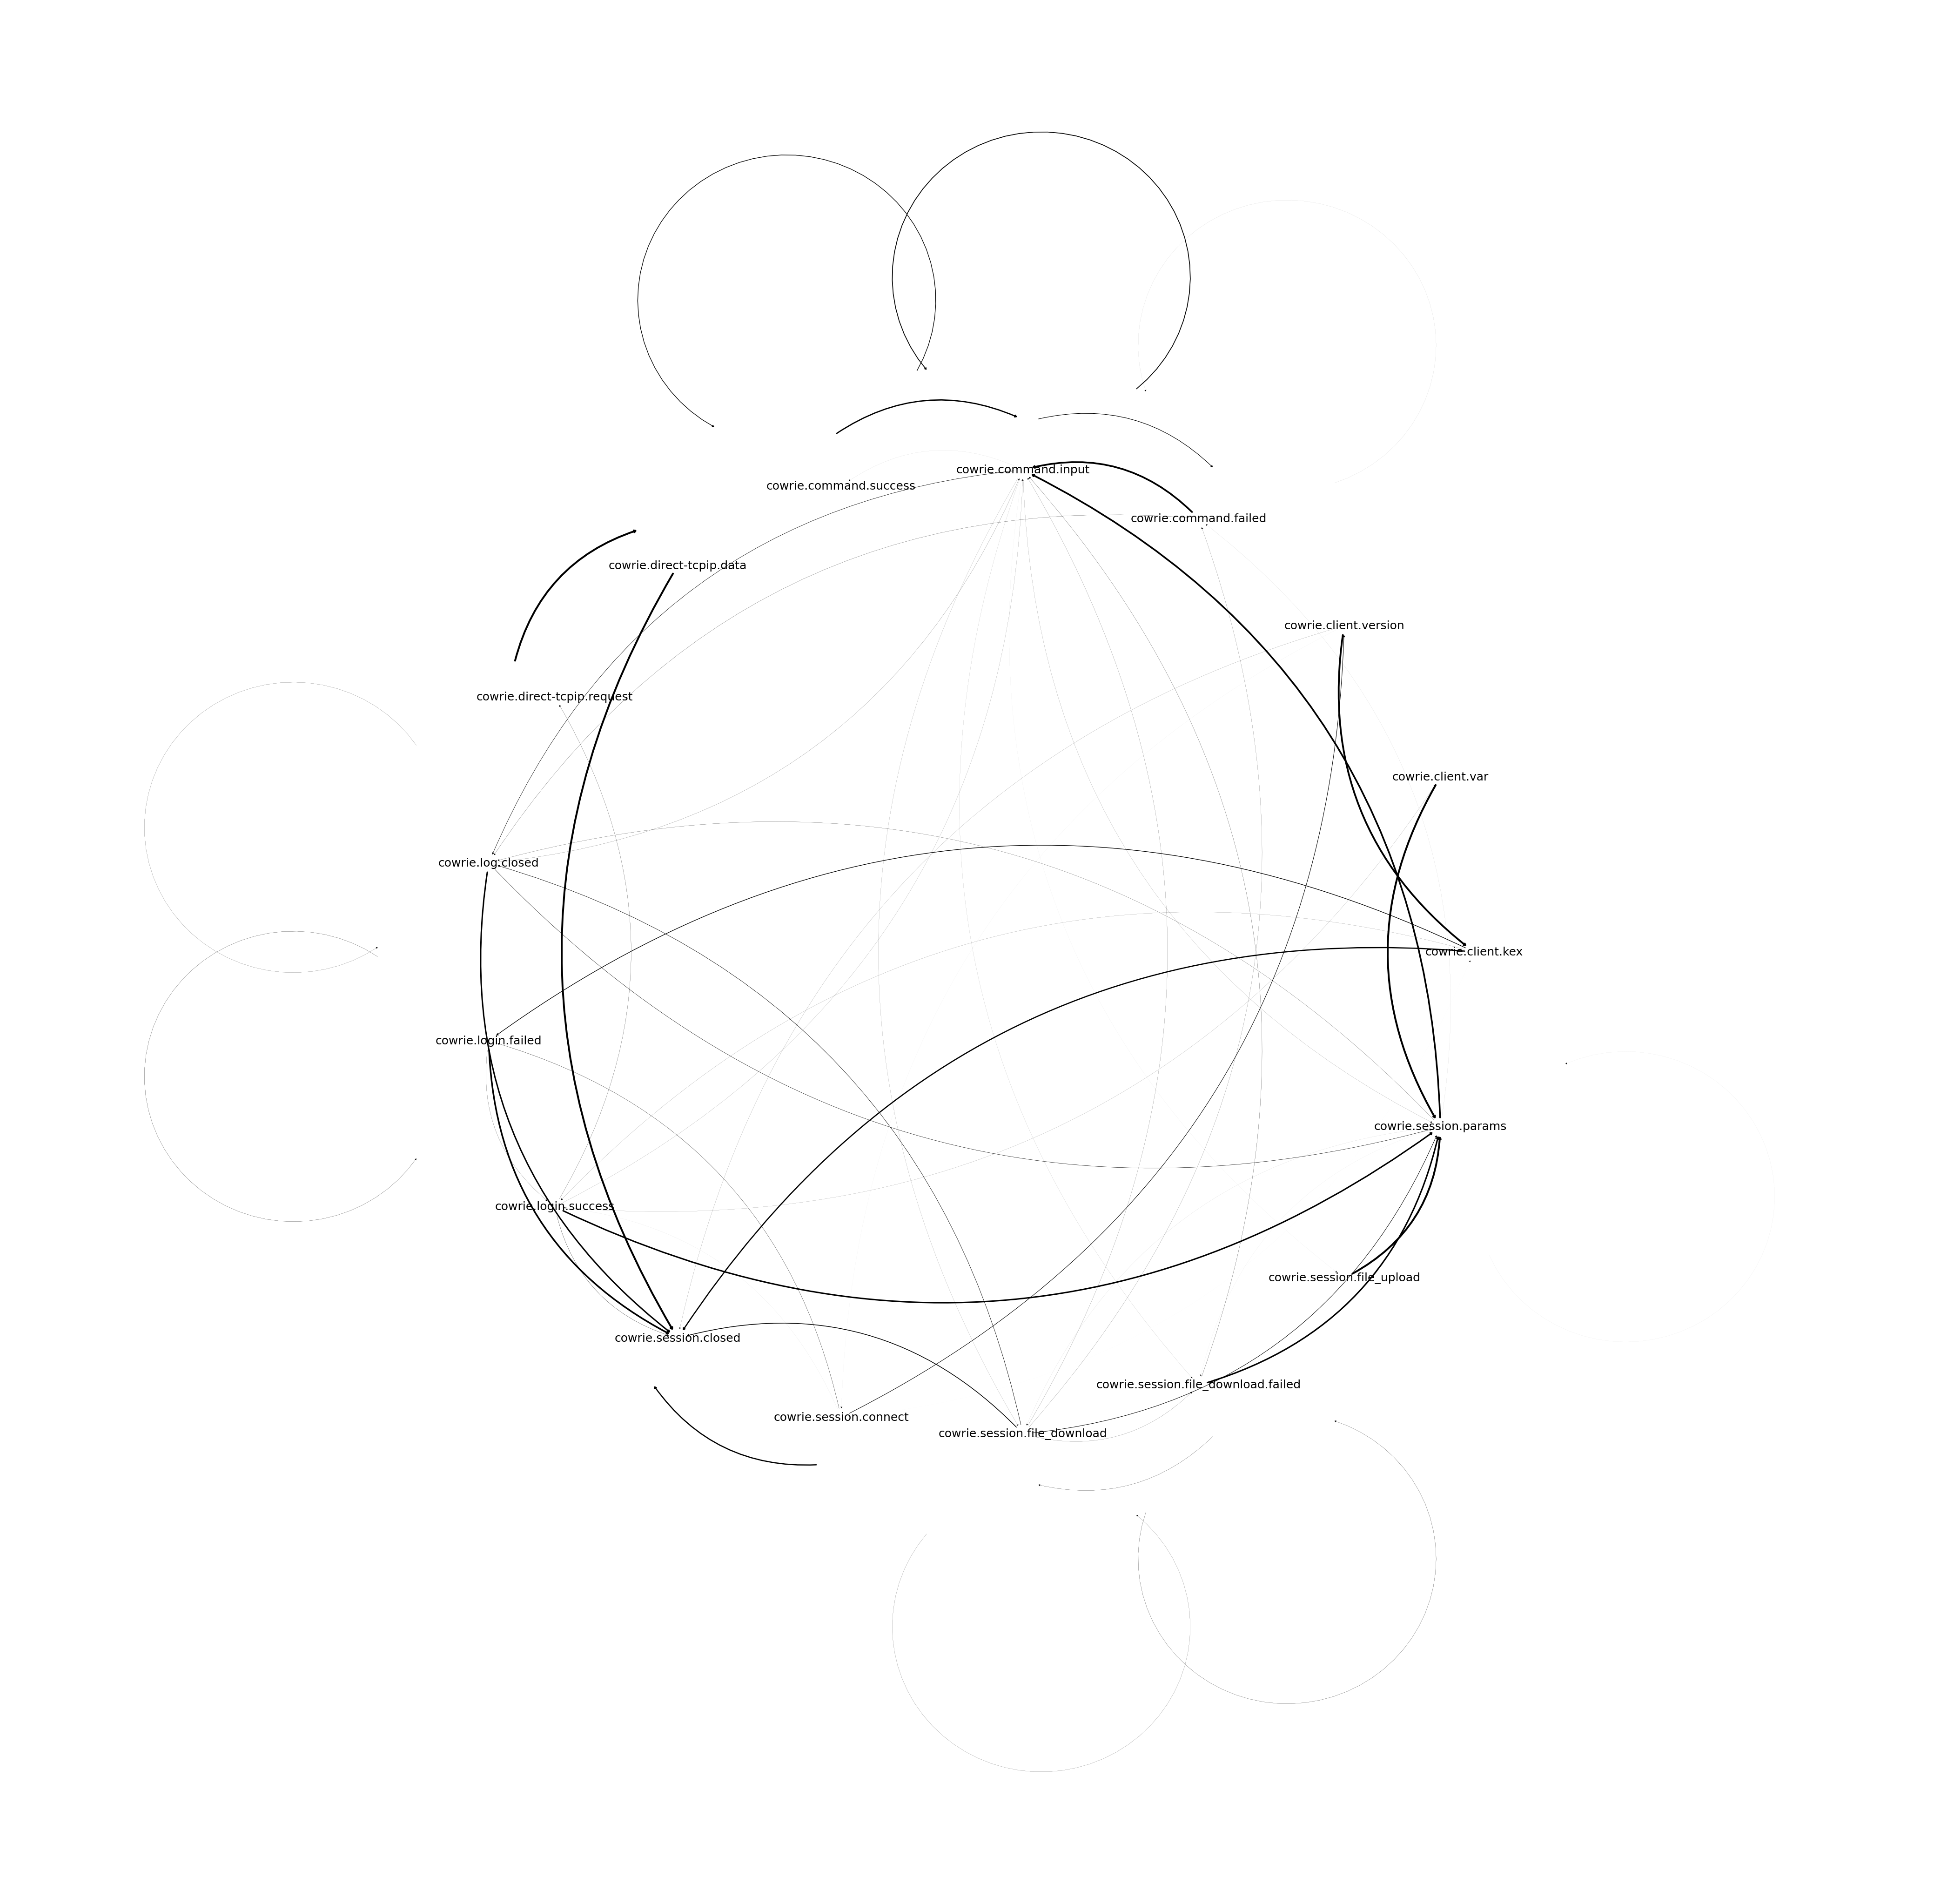

Number of sequences: 3973


         1      -31974.3624             +nan
         2      -19334.0575      +12640.3050
         3      -18173.4849       +1160.5726
         4      -16079.1307       +2094.3541
         5      -12953.6059       +3125.5249
         6      -10275.6341       +2677.9718
         7       -8782.2510       +1493.3831
         8       -7953.0670        +829.1840
         9       -7540.3058        +412.7612
        10       -7327.1537        +213.1521
        11       -7218.7043        +108.4494
        12       -7155.9870         +62.7173
        13       -7107.1431         +48.8439
        14       -7064.5883         +42.5548
        15       -7027.6018         +36.9866
        16       -6995.4692         +32.1326
        17       -6965.7574         +29.7118
        18       -6934.2995         +31.4579
        19       -6898.4952         +35.8043
        20       -6865.3604         +33.1348


{'city': 'Melbourne',
 'code_name': 'deadinlay',
 'country': 'Austrailia',
 'ip': '67.219.98.203'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54560 entries, 0 to 54559
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   @version         54560 non-null  object 
 1   message          54558 non-null  object 
 2   headers          54560 non-null  object 
 3   path             54560 non-null  object 
 4   keyAlgs          7110 non-null   object 
 5   t-pot_hostname   54560 non-null  object 
 6   host             54560 non-null  object 
 7   type             54560 non-null  object 
 8   geoip            54560 non-null  object 
 9   t-pot_ip_int     54560 non-null  object 
 10  ip_rep           20500 non-null  object 
 11  timestamp        54560 non-null  object 
 12  sensor           54560 non-null  object 
 13  session          54560 non-null  object 
 14  hasshAlgorithms  7110 non-null   object 
 15  event

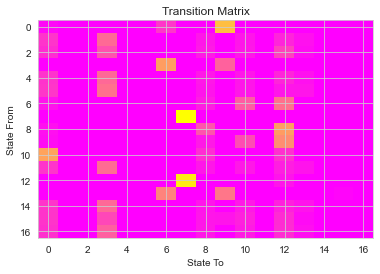

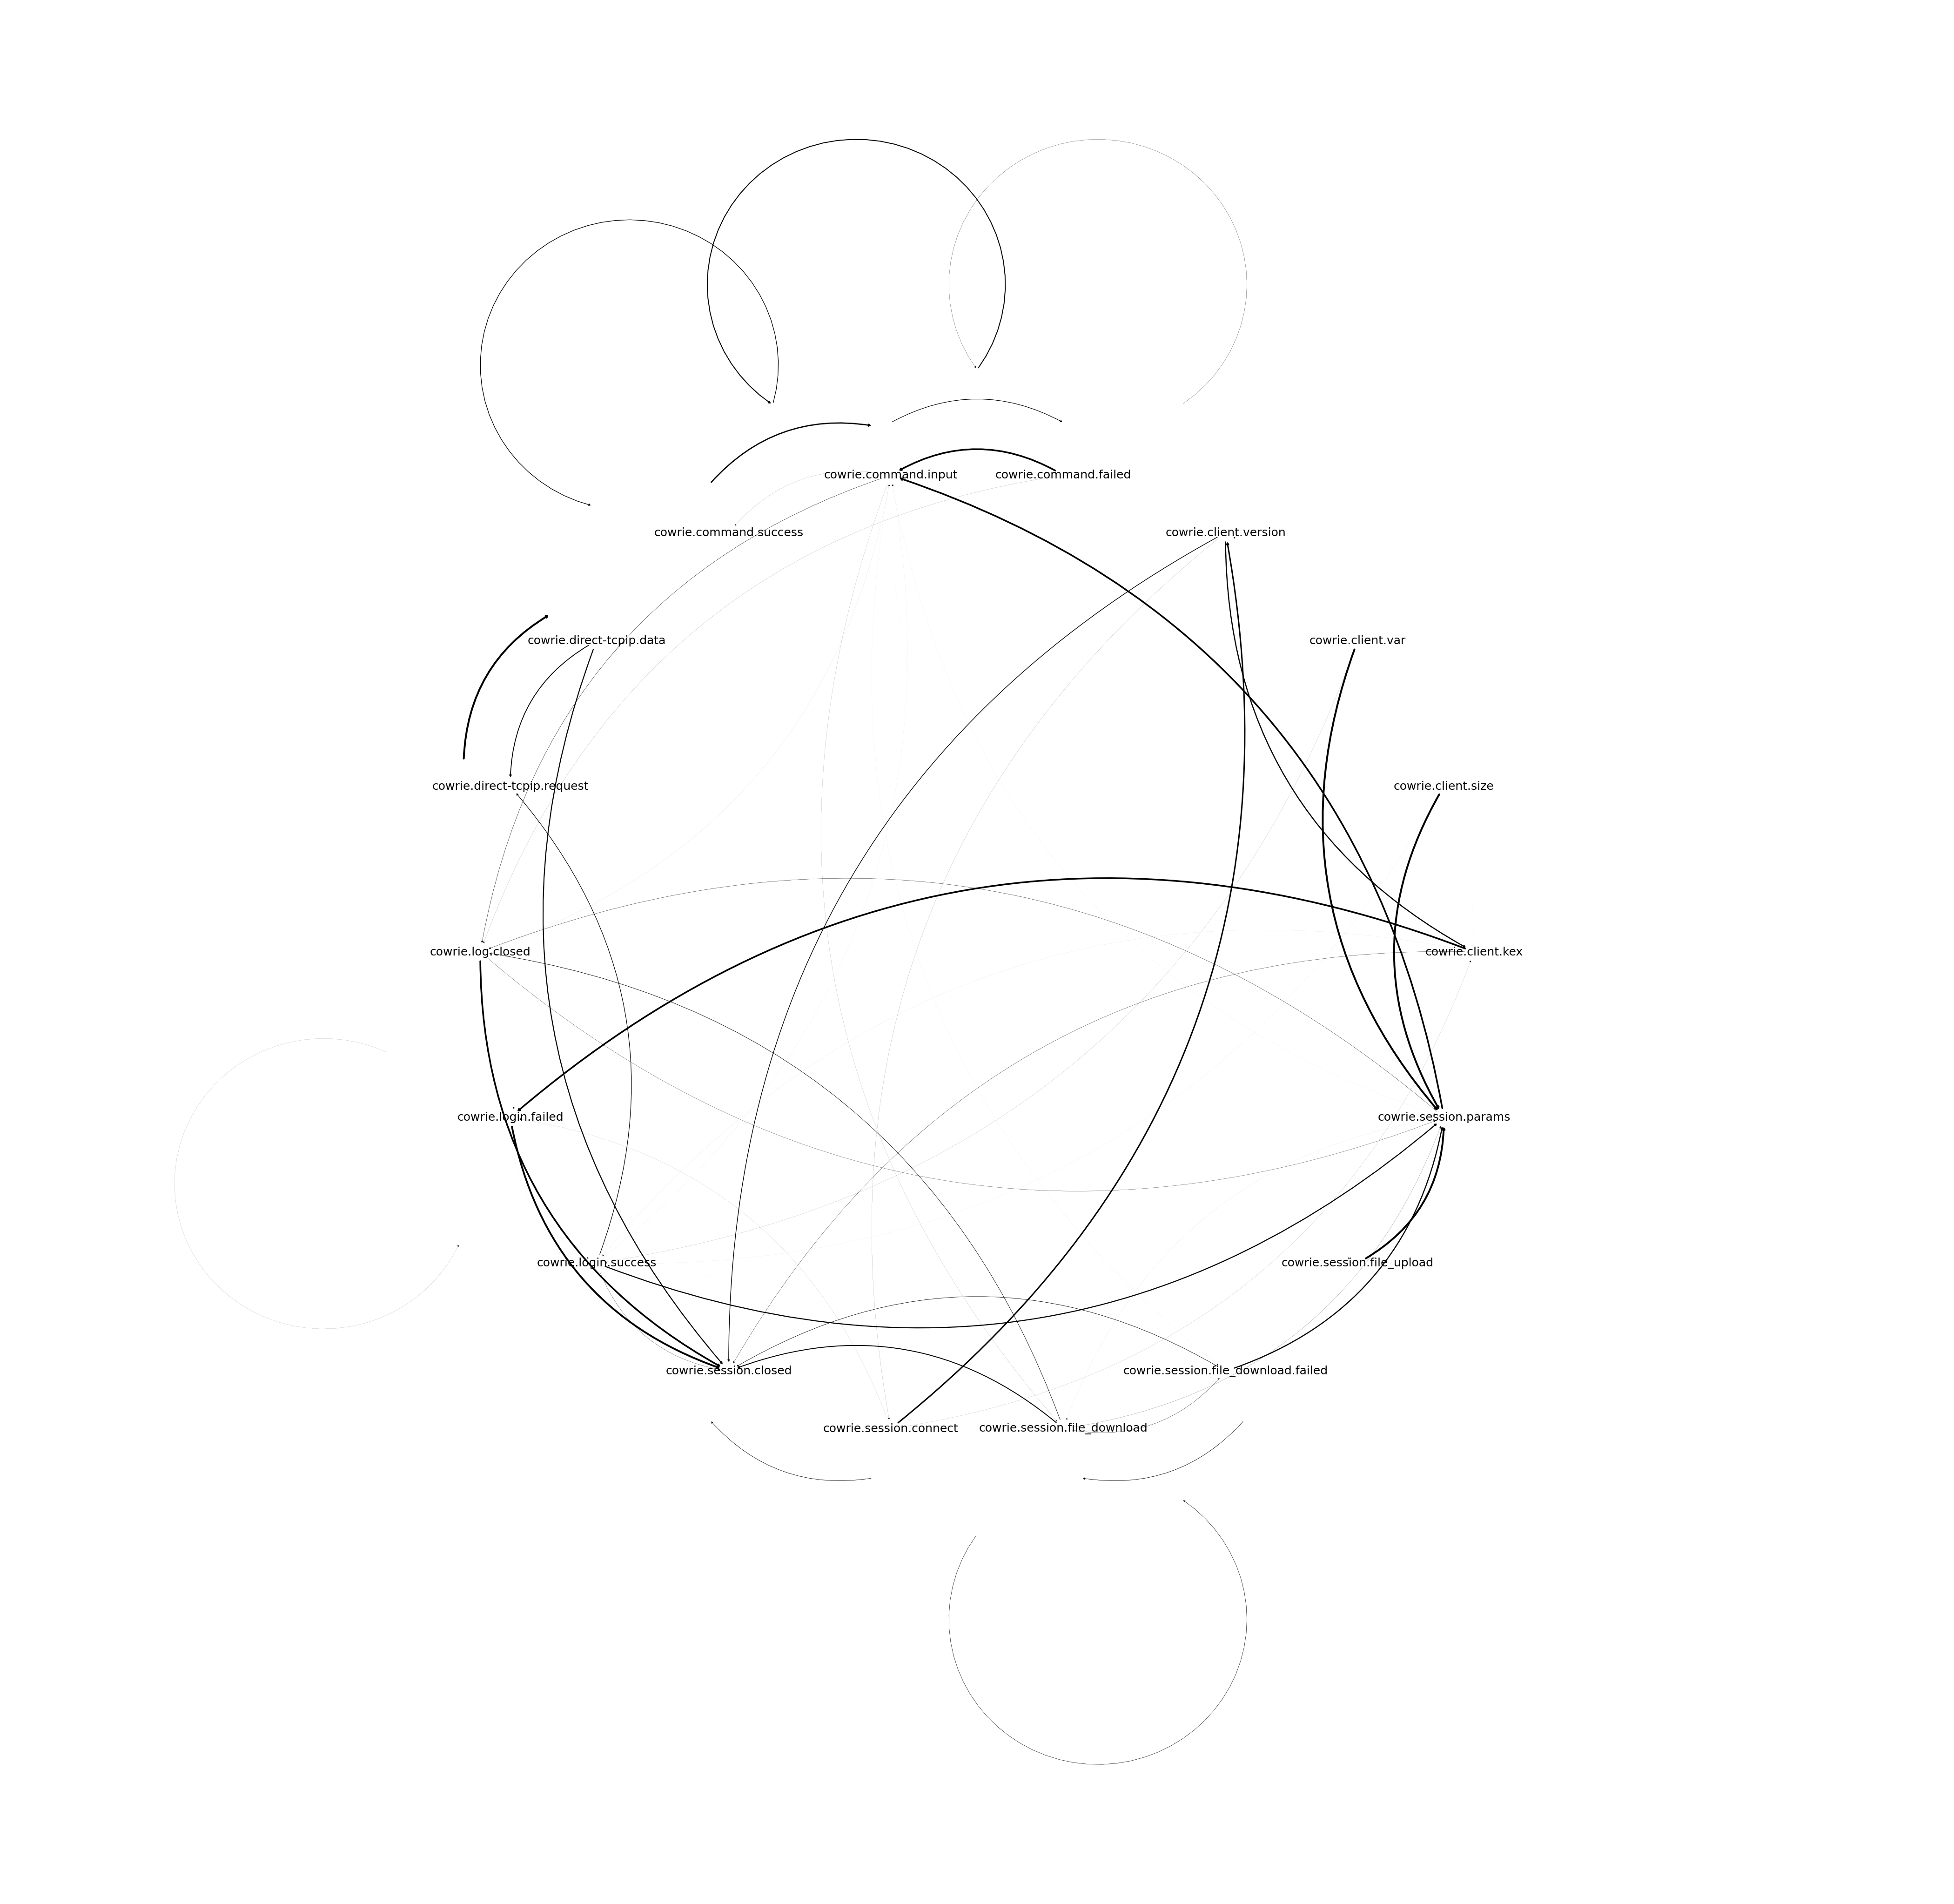

Number of sequences: 14213


         1     -160924.5965             +nan
         2      -88099.5189      +72825.0776
         3      -82740.5752       +5358.9438
         4      -70627.8525      +12112.7227
         5      -52434.3153      +18193.5372
         6      -40476.6373      +11957.6779
         7      -35021.1266       +5455.5107
         8      -31819.5107       +3201.6160
         9      -29628.2829       +2191.2278
        10      -27791.7130       +1836.5699
        11      -26335.7249       +1455.9881
        12      -25531.4107        +804.3142
        13      -24990.0590        +541.3517
        14      -24513.2371        +476.8219
        15      -24134.3946        +378.8426
        16      -23895.3947        +238.9999
        17      -23770.5582        +124.8365
        18      -23690.1894         +80.3688
        19      -23639.4263         +50.7631
        20      -23611.1683         +28.2581


{'city': 'Stockholm',
 'code_name': 'longtermresult',
 'country': 'Sweden',
 'ip': '65.20.115.181'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102800 entries, 0 to 102799
Data columns (total 54 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   @version         102800 non-null  object 
 1   message          102783 non-null  object 
 2   geoip_ext        102800 non-null  object 
 3   src_ip           102800 non-null  object 
 4   @timestamp       102800 non-null  object 
 5   t-pot_ip_int     102800 non-null  object 
 6   type             102800 non-null  object 
 7   host             102800 non-null  object 
 8   eventid          102800 non-null  object 
 9   sensor           102800 non-null  object 
 10  session          102800 non-null  object 
 11  headers          102800 non-null  object 
 12  t-pot_ip_ext     102800 non-null  object 
 13  duration         32962 non-null   float64
 14  geoip            102800 non-null

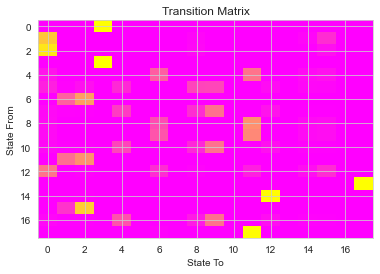

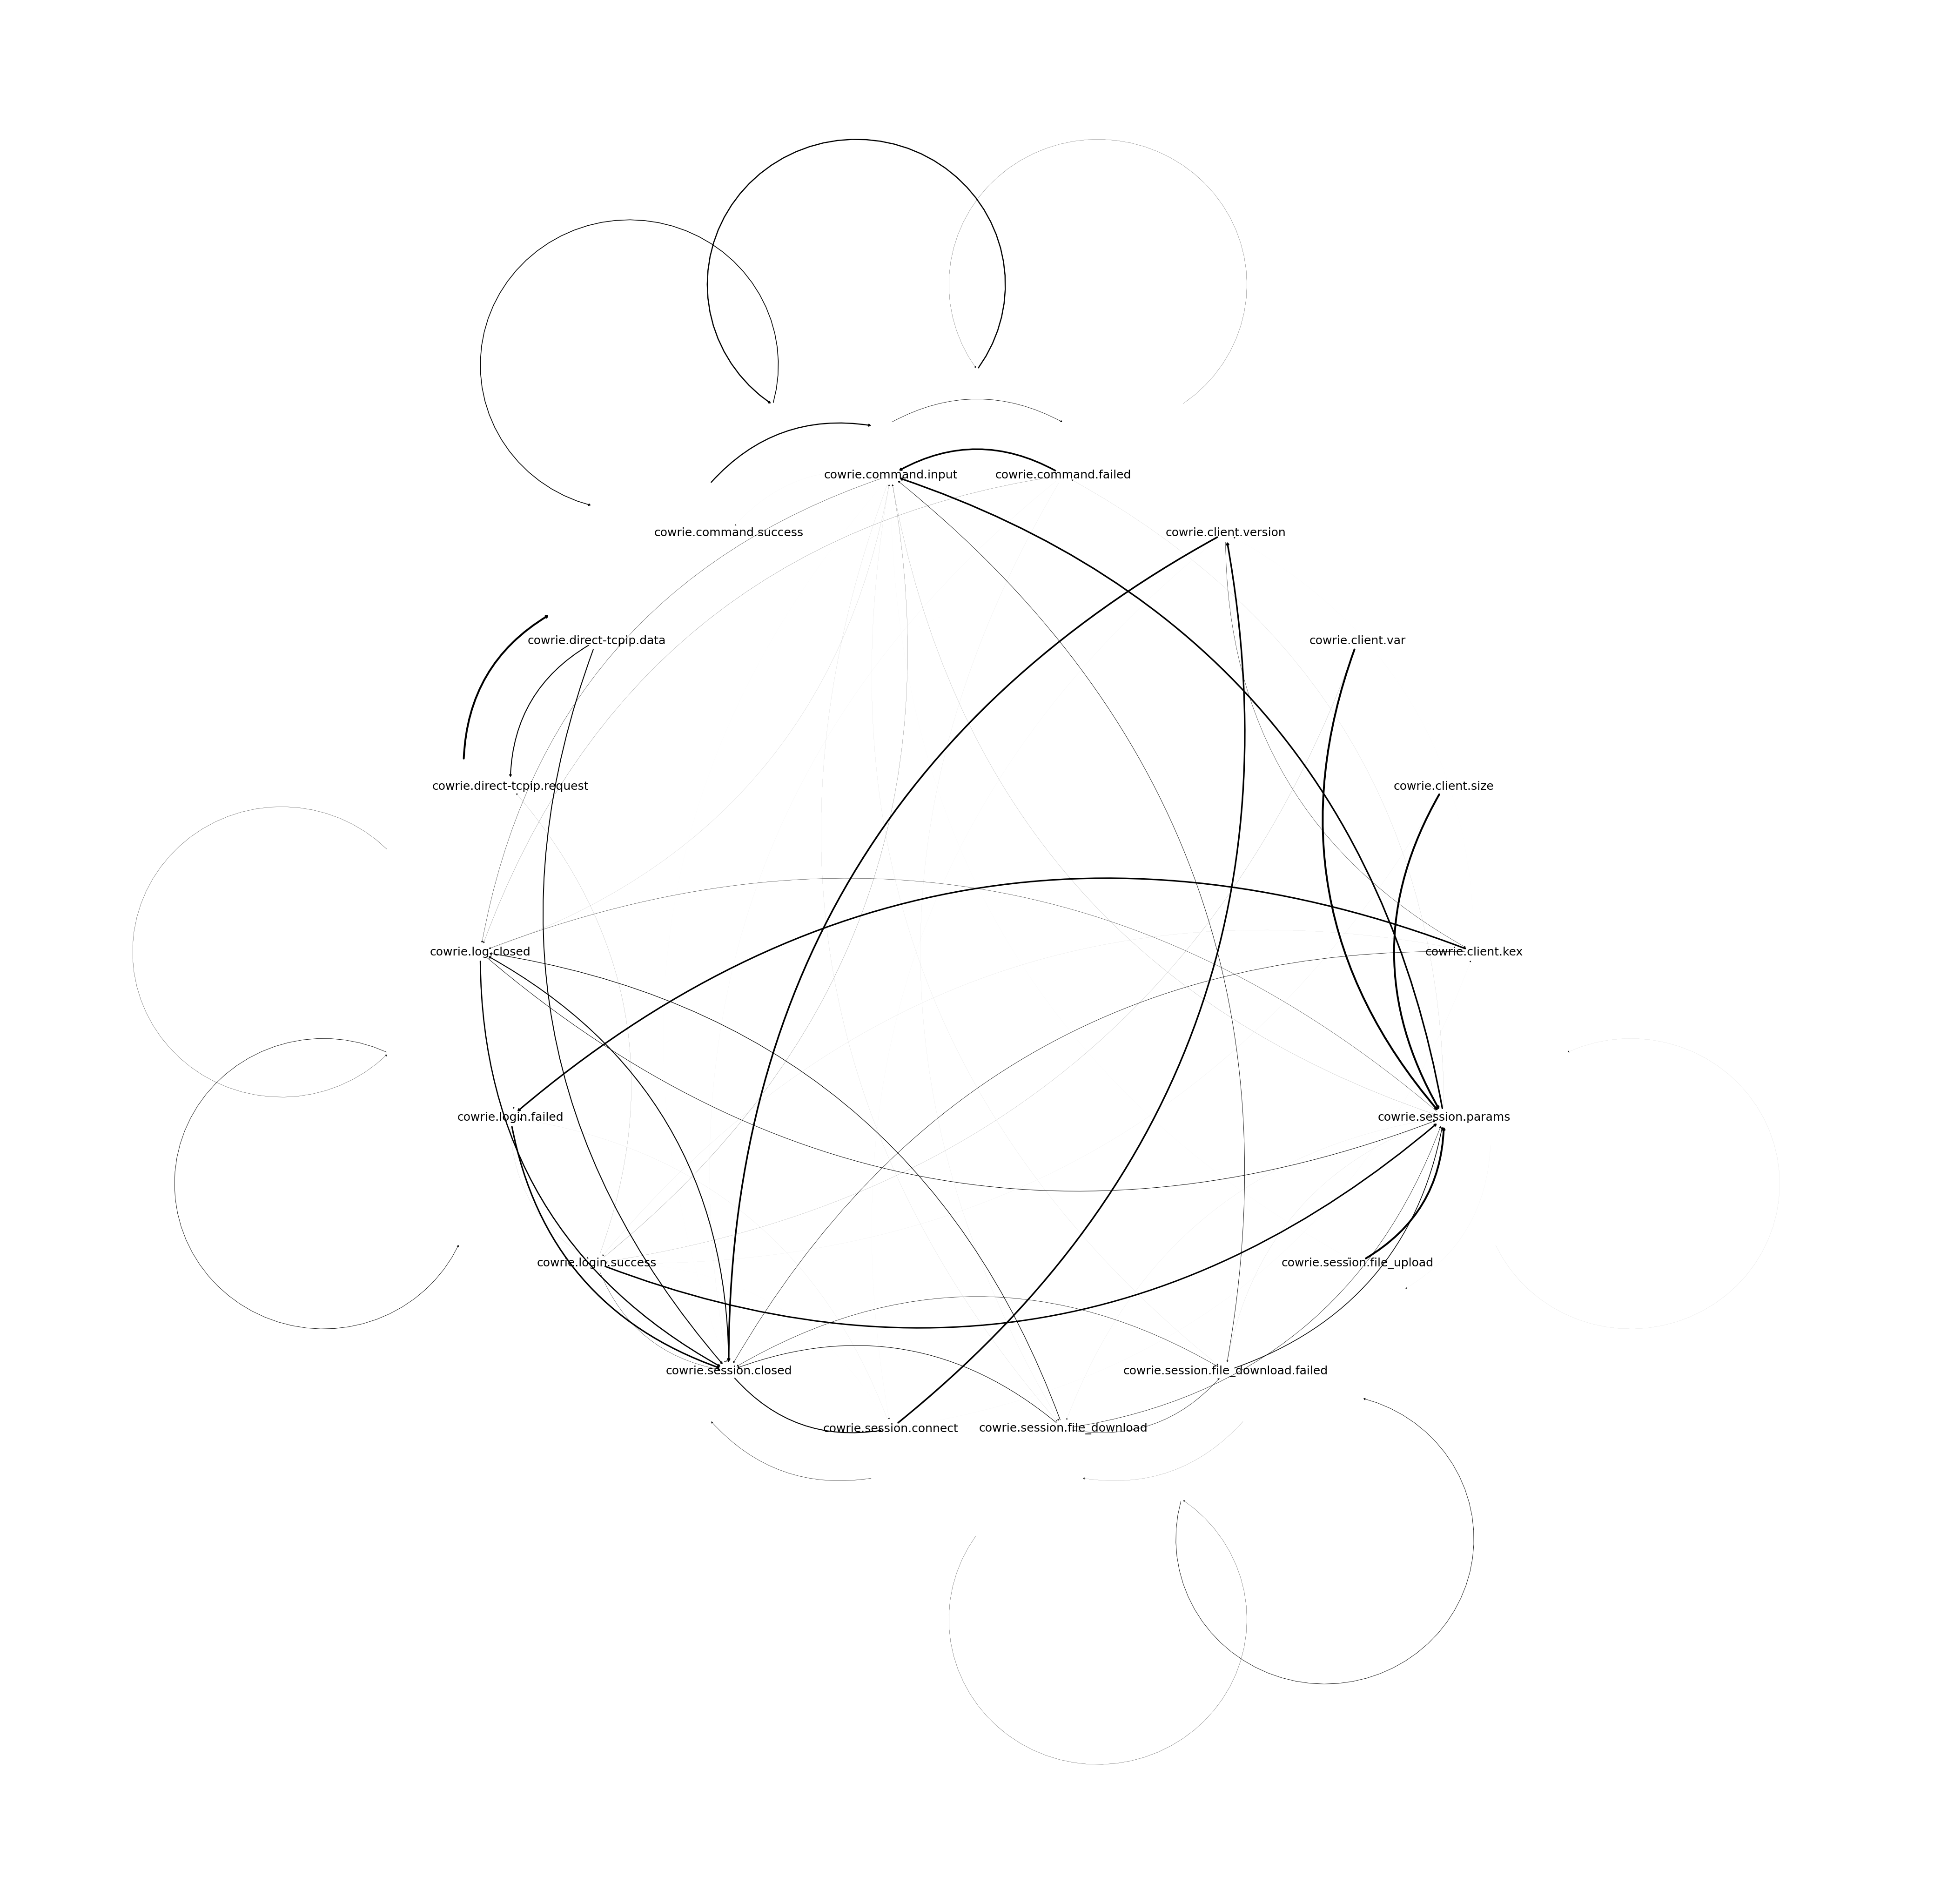

Number of sequences: 32788


         1     -309476.0531             +nan
         2     -128392.1584     +181083.8947
         3     -109580.6295      +18811.5289
         4      -88413.9250      +21166.7044
         5      -70700.5701      +17713.3549
         6      -58469.6961      +12230.8740
         7      -50272.4257       +8197.2704
         8      -44818.2561       +5454.1697
         9      -40463.3901       +4354.8660
        10      -37563.8867       +2899.5034
        11      -36027.6875       +1536.1992
        12      -35282.9074        +744.7800
        13      -34912.9660        +369.9414
        14      -34651.6200        +261.3461
        15      -34461.7013        +189.9187
        16      -34318.5882        +143.1130
        17      -34193.4644        +125.1238
        18      -34074.9340        +118.5305
        19      -33967.8179        +107.1160
        20      -33887.9597         +79.8582


{'city': 'Mumbai',
 'code_name': 'sadproduce',
 'country': 'India',
 'ip': '65.20.68.106'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48397 entries, 0 to 48396
Data columns (total 51 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geoip_ext        48397 non-null  object 
 1   message          48384 non-null  object 
 2   tags             48397 non-null  object 
 3   @version         48397 non-null  object 
 4   protocol         11433 non-null  object 
 5   geoip            48397 non-null  object 
 6   session          48397 non-null  object 
 7   src_ip           48397 non-null  object 
 8   @timestamp       48397 non-null  object 
 9   host             48397 non-null  object 
 10  sensor           48397 non-null  object 
 11  type             48397 non-null  object 
 12  path             48397 non-null  object 
 13  t-pot_ip_int     48397 non-null  object 
 14  eventid          48397 non-null  object 
 15  t-pot_hostnam

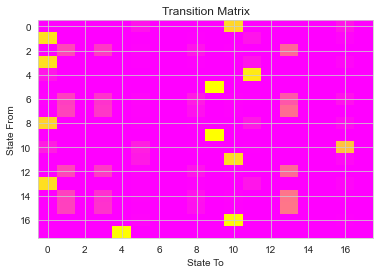

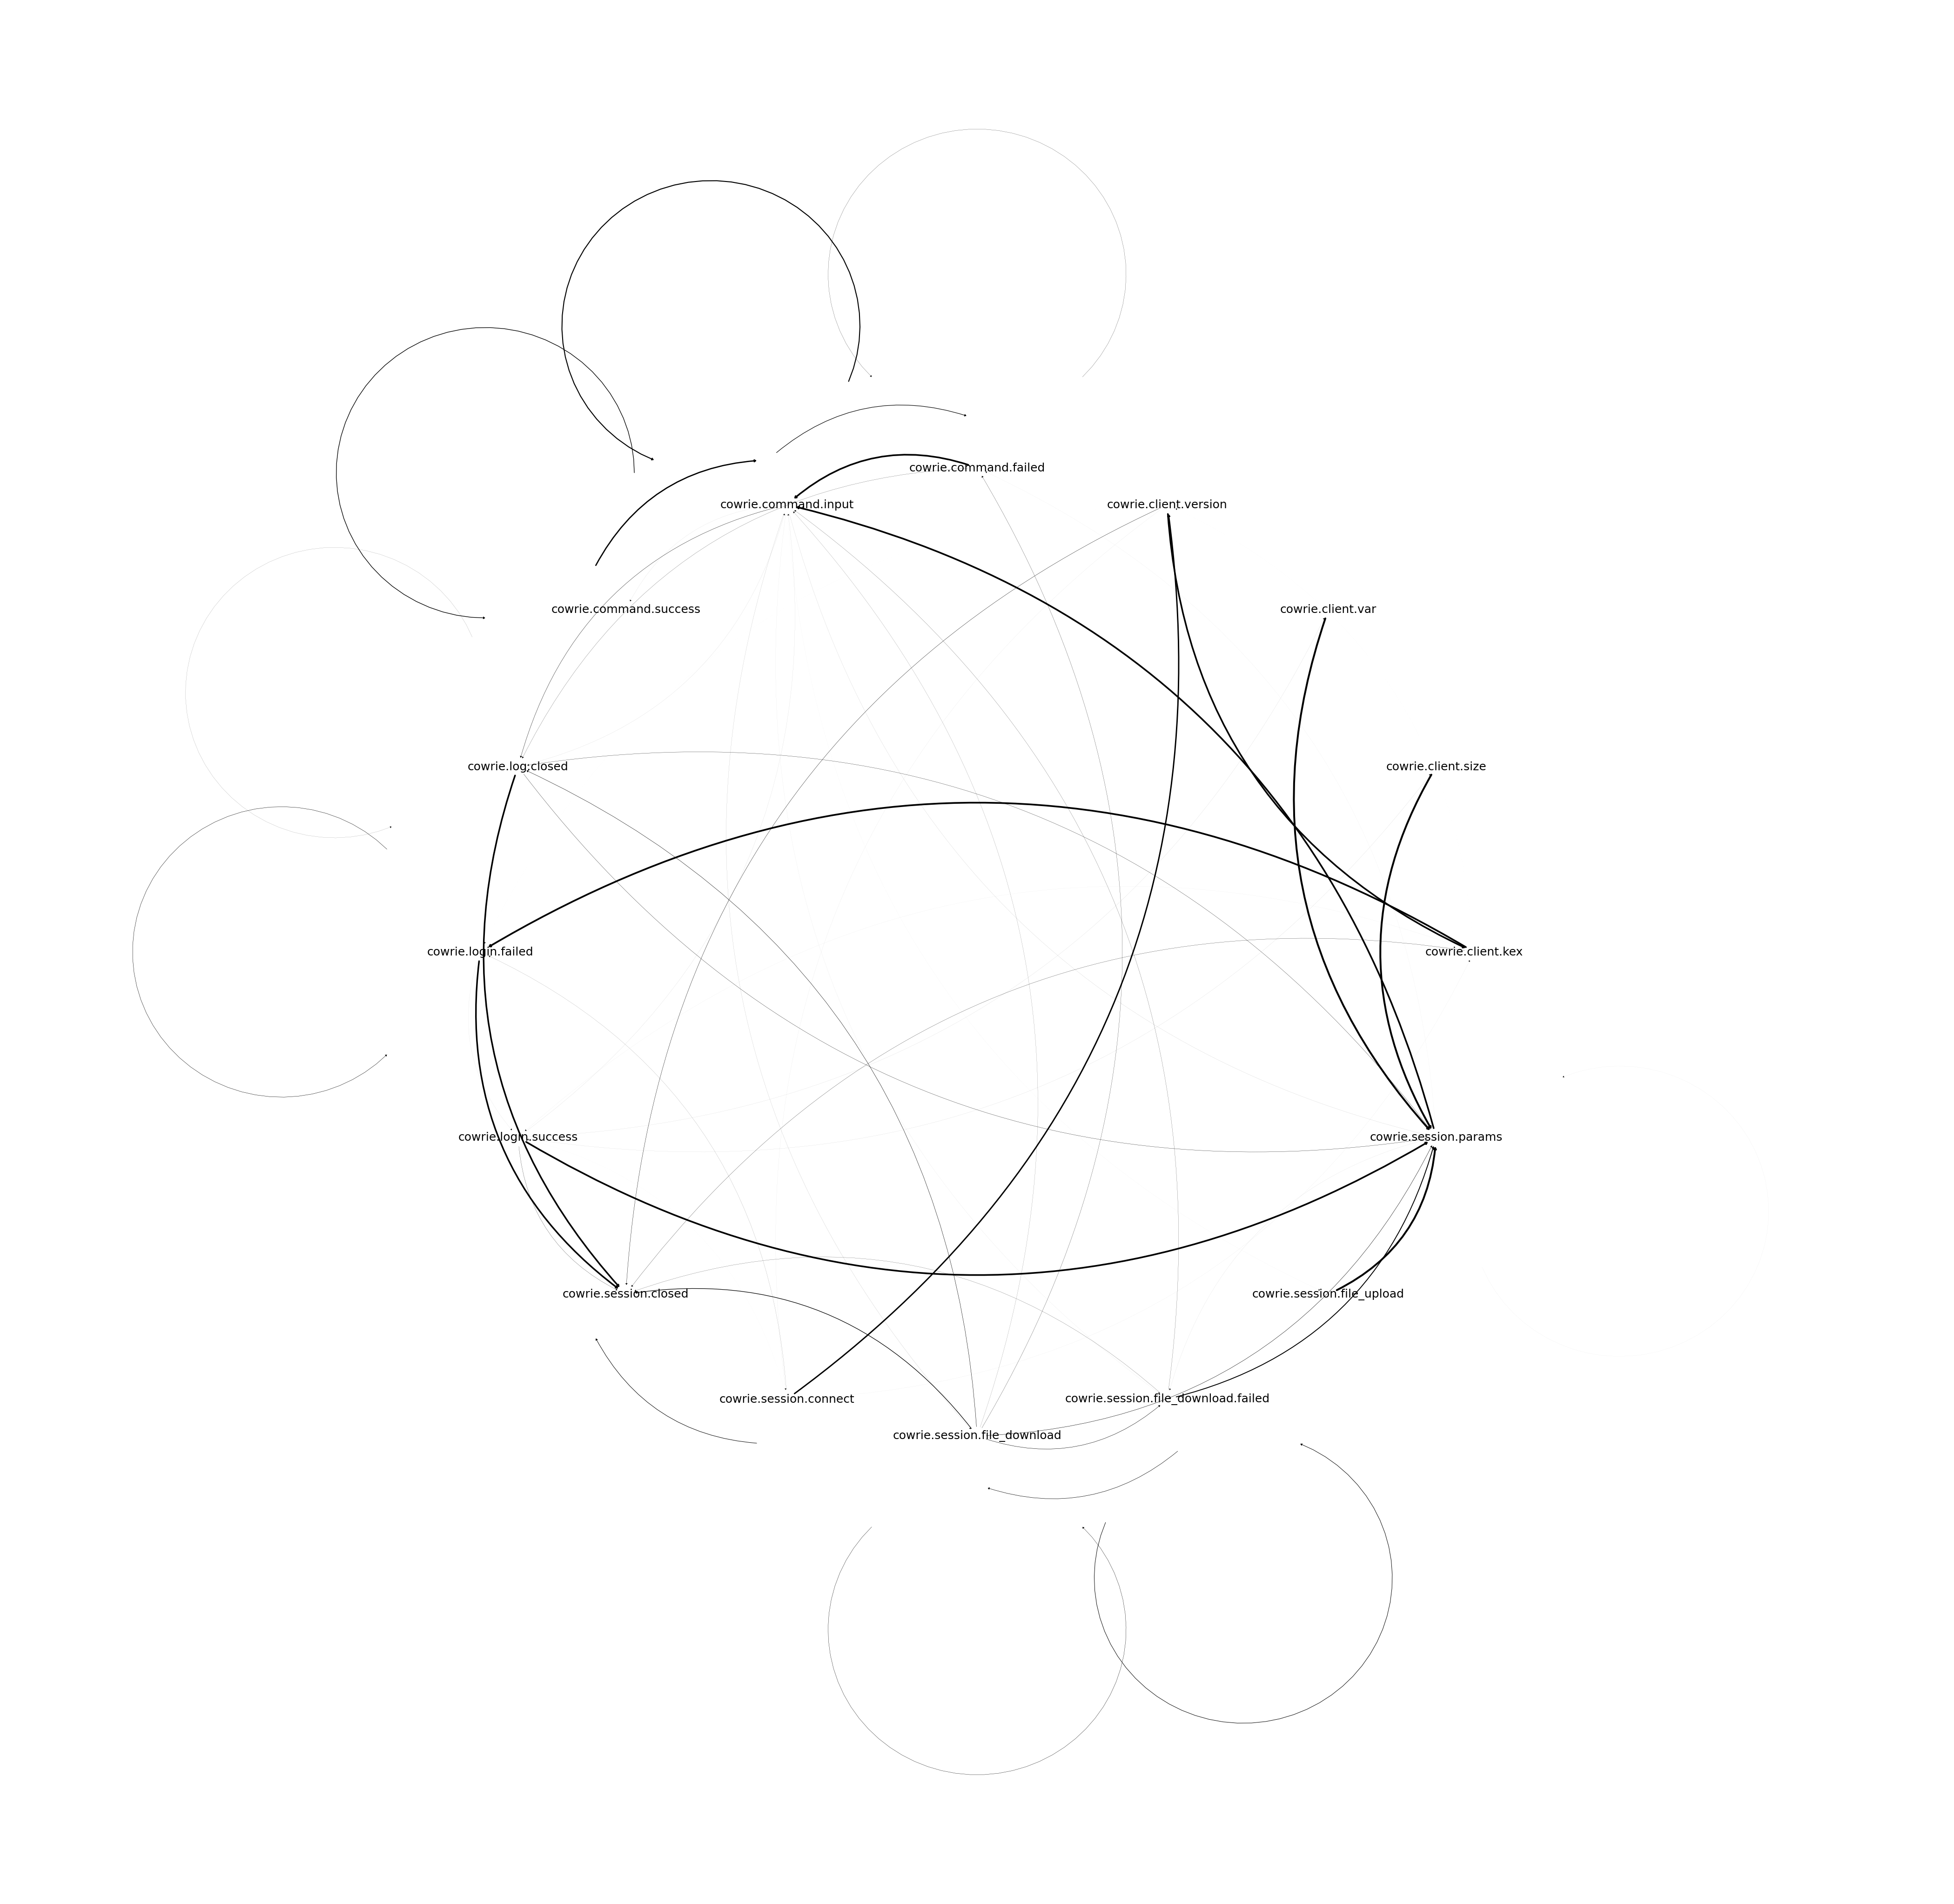

Number of sequences: 11435


         1     -135877.8317             +nan
         2      -80411.2329      +55466.5988
         3      -74320.5543       +6090.6786
         4      -62661.4242      +11659.1301
         5      -47296.3122      +15365.1120
         6      -33402.5451      +13893.7671
         7      -26430.3735       +6972.1716
         8      -23838.5661       +2591.8074
         9      -22473.4897       +1365.0764
        10      -21495.3484        +978.1413
        11      -20667.0561        +828.2923
        12      -20252.2493        +414.8068
        13      -20142.6189        +109.6303
        14      -20073.0081         +69.6108
        15      -19909.1670        +163.8411
        16      -19563.5355        +345.6315
        17      -19356.6241        +206.9114
        18      -19289.3959         +67.2282
        19      -19265.7173         +23.6785
        20      -19248.1398         +17.5776


{'city': 'Los Angeles',
 'code_name': 'resonantnorse',
 'country': 'United States',
 'ip': '149.248.9.4'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81220 entries, 0 to 81219
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   message          81213 non-null  object 
 1   @timestamp       81220 non-null  object 
 2   type             81220 non-null  object 
 3   dest_port        27076 non-null  float64
 4   dest_ip          27076 non-null  object 
 5   host             81220 non-null  object 
 6   src_port         27057 non-null  float64
 7   session          81220 non-null  object 
 8   timestamp        81220 non-null  object 
 9   @version         81220 non-null  object 
 10  geoip_ext        81220 non-null  object 
 11  src_ip           81220 non-null  object 
 12  t-pot_ip_int     81220 non-null  object 
 13  event            11234 non-null  object 
 14  eventid          81220 non-null  object 
 15

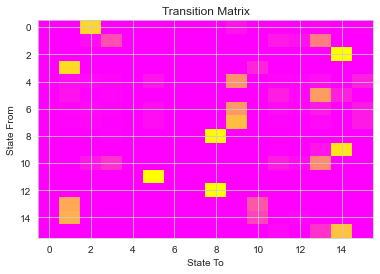

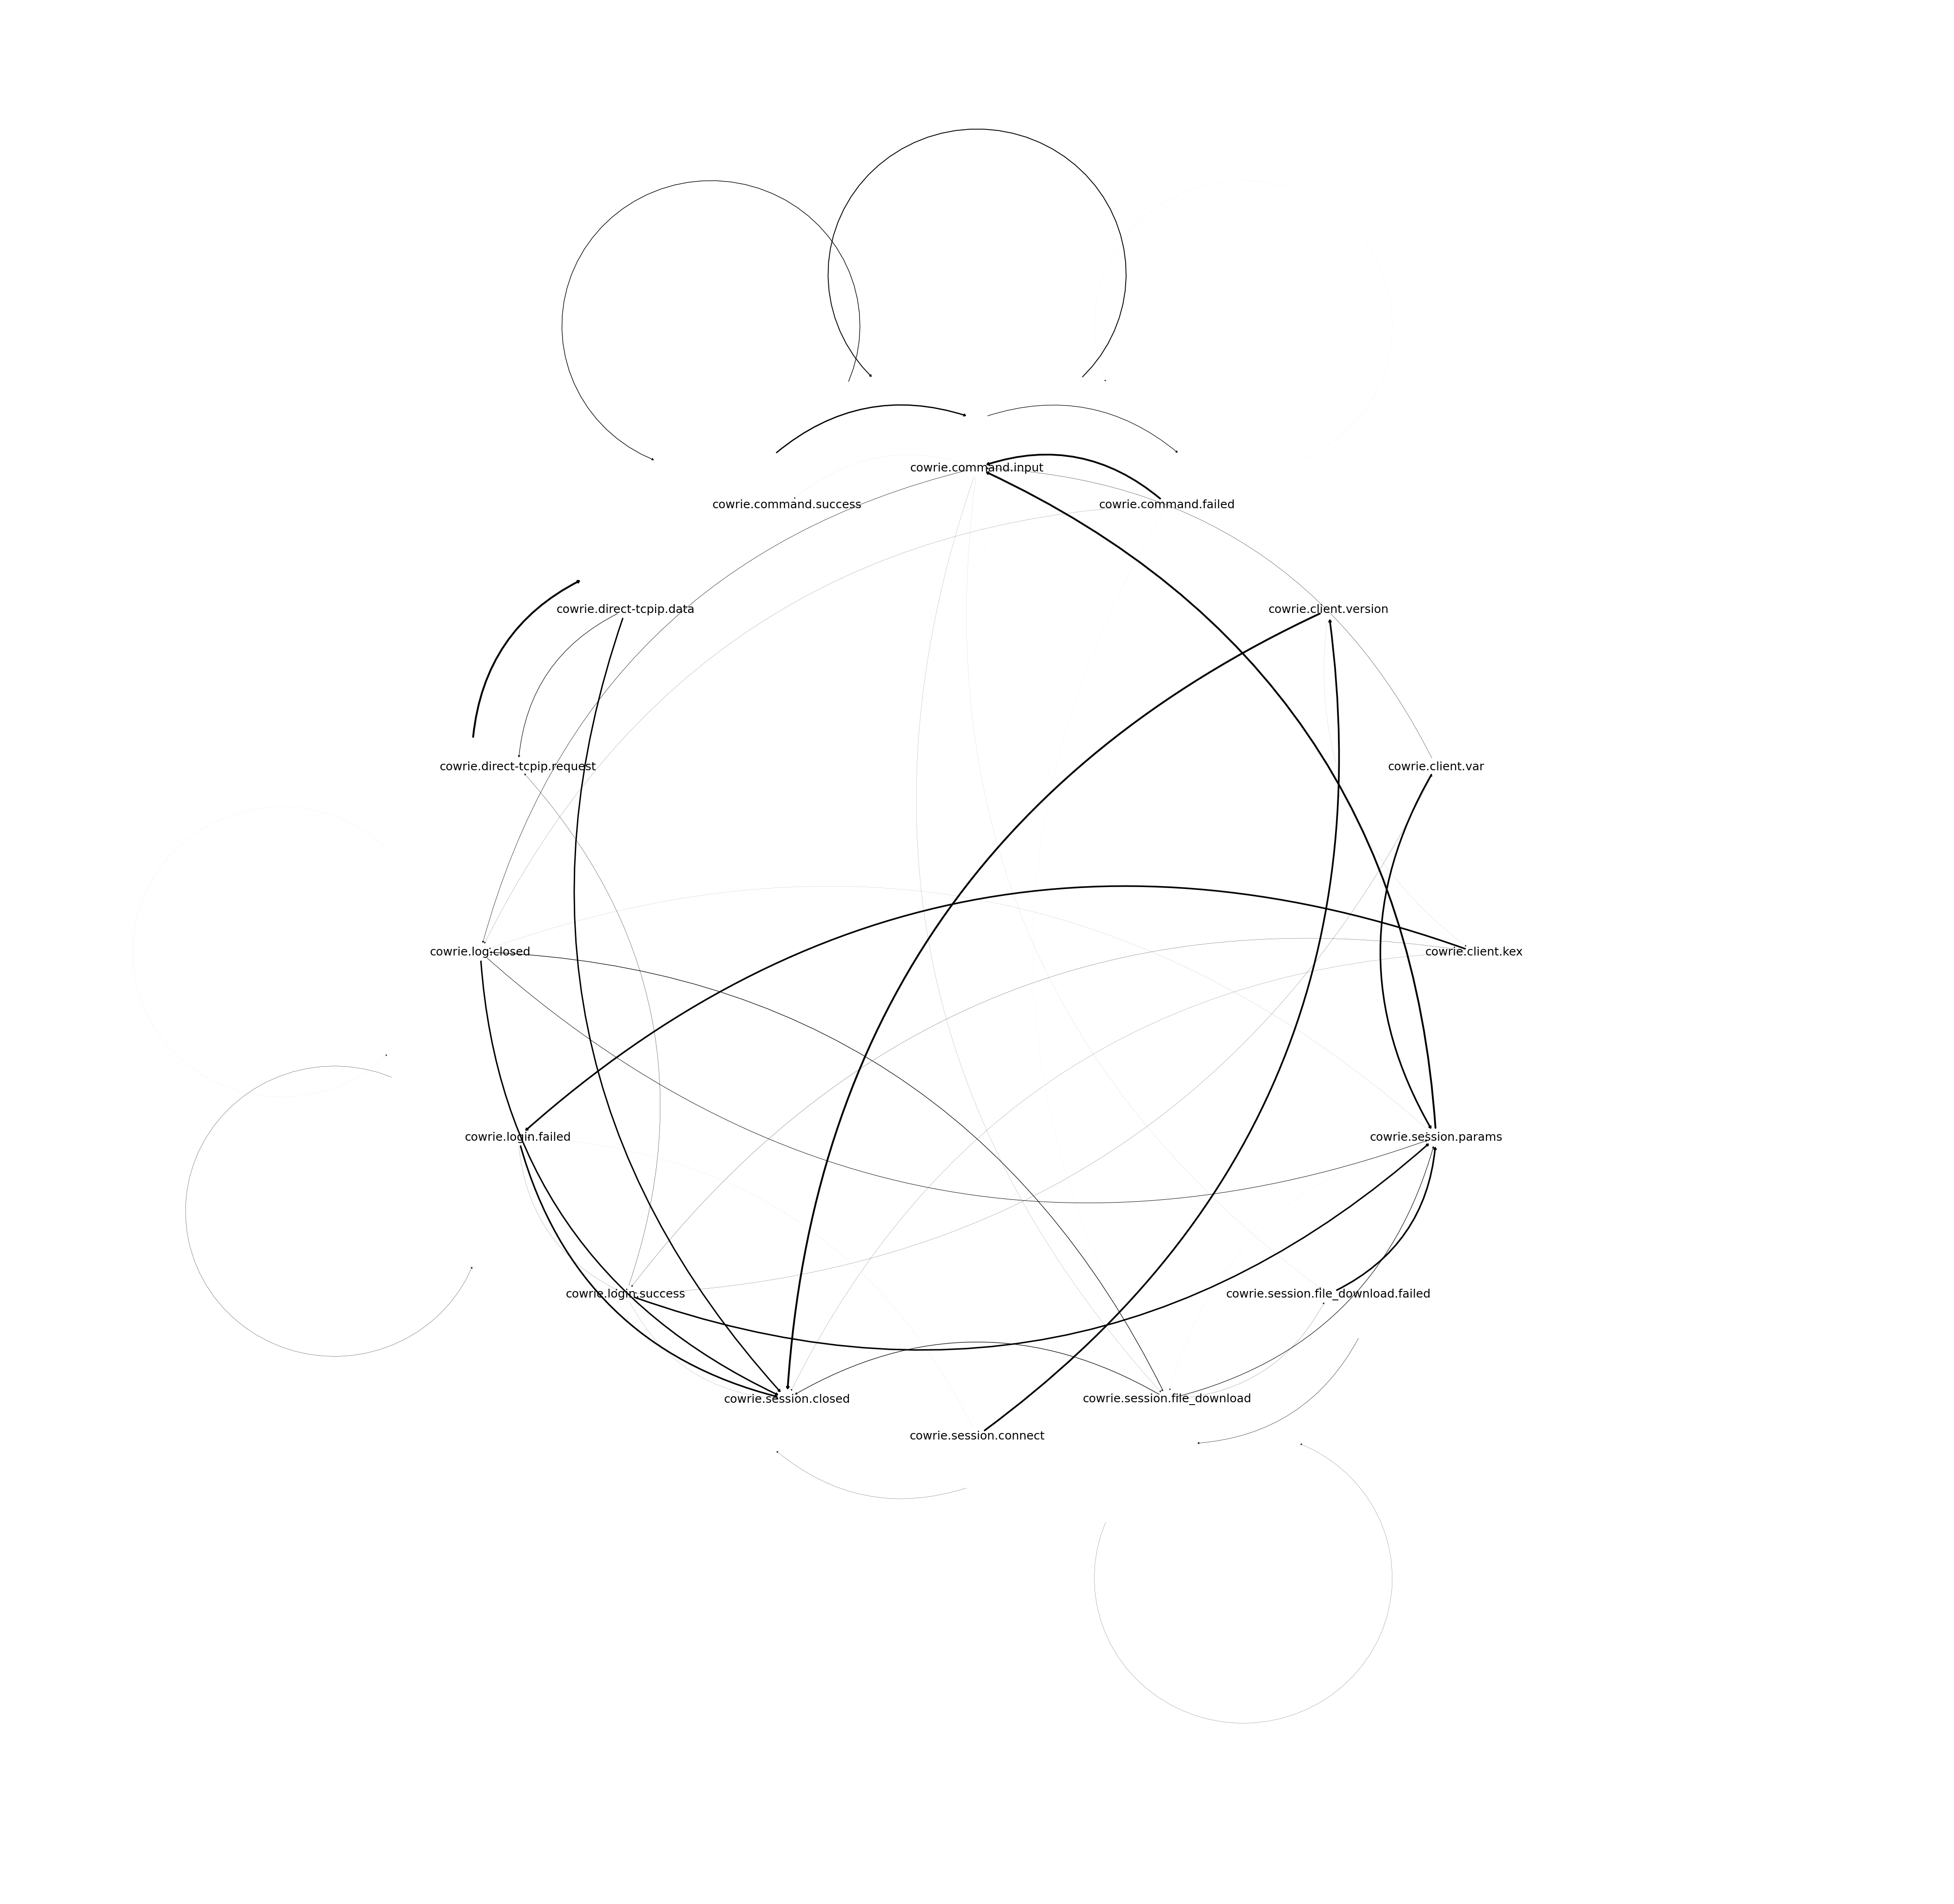

Number of sequences: 27039


         1     -216567.0704             +nan
         2      -95705.1575     +120861.9129
         3      -79725.9772      +15979.1803
         4      -54023.1324      +25702.8448
         5      -34283.1315      +19740.0009
         6      -24748.0285       +9535.1030
         7      -20389.4337       +4358.5948
         8      -18520.7247       +1868.7090
         9      -17661.7216        +859.0031
        10      -17128.0067        +533.7149
        11      -16858.0278        +269.9789
        12      -16729.0178        +129.0101
        13      -16649.9667         +79.0510
        14      -16597.9769         +51.9898
        15      -16565.3393         +32.6376
        16      -16548.3016         +17.0377
        17      -16539.7491          +8.5525
        18      -16535.3320          +4.4171
        19      -16532.6201          +2.7119
        20      -16530.2127          +2.4074


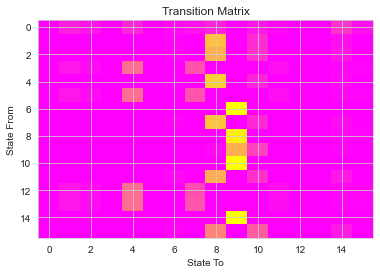

In [26]:
my_models = []
for idx, (df, hive_sensor) in enumerate(zip(dfs, hive_sensors)):
    pprint(vars(hive_sensor))
    print(f"{df.info()}")
    my_models.append(process_dataframe(idx + 1, df))

In [28]:
for my_model, hive_sensor in zip(my_models, hive_sensors):
    pprint(vars(hive_sensor))
    model_pom = my_model[0]
    model_hmm = my_model[1]
    np_fit_data_hmm = my_model[2]
    np_fit_data_lengths = my_model[3]
    print(f"Number of Sequences: {len(np_fit_data_lengths)}")
    try:
        # print(model_hmm.transmat_)
        score = model_hmm.score(X=np_fit_data_hmm, lengths=np_fit_data_lengths)
        print(score)
        # print(model_hmm.predict(numpy.array([[13], [3], [9]]), lengths=[3]))
    except Exception as e:
        print(f"hmmlearn model failed to build {e}")
        traceback.print_exc()
    try:
        # print(model_pom.probability([[13, 3, 9]]))
        pass
    except Exception as e:
        print(f"promegranate model failed to build {e}")
        traceback.print_exc()

{'city': 'Toronto',
 'code_name': 'rulingcommittee',
 'country': 'Canada',
 'ip': '216.238.83.8'}
12131
-21514.36465916146
{'city': 'Seoul',
 'code_name': 'attractivescow',
 'country': 'Korea',
 'ip': '158.247.238.143'}
3973
-6845.826437526963
{'city': 'Melbourne',
 'code_name': 'deadinlay',
 'country': 'Austrailia',
 'ip': '67.219.98.203'}
14213
-23592.781711660155
{'city': 'Stockholm',
 'code_name': 'longtermresult',
 'country': 'Sweden',
 'ip': '65.20.115.181'}
32788
-33832.91060668411
{'city': 'Mumbai',
 'code_name': 'sadproduce',
 'country': 'India',
 'ip': '65.20.68.106'}
11435
-19231.69921274217
{'city': 'Los Angeles',
 'code_name': 'resonantnorse',
 'country': 'United States',
 'ip': '149.248.9.4'}
27039
-16527.209799049913
